In [16]:
from utilities.setup_environment import *
from utilities.utilities import *
from utilities.plotting import *
from utilities.getStim import *
pd.set_option('display.max_columns', None)
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_context("poster")
from scipy.stats import sem
import os

In [ ]:
csv_files = [f for f in os.listdir("results") if f.endswith(".csv")]
frame_rate = 60

In [38]:
len(csv_files)

3


Processing: OFF sustained alpha 
Converted the following columns to NumPy arrays:
  - freq
  - stim_psd
  - rs_spikes_psd
  - nr_spikes_psd
  - H_f_power_rs
  - H_f_power_nr
  - stim_autocorr
  - spikes_autocorr_rs
  - spikes_autocorr_nr

Processing: OFF transient alpha 
Converted the following columns to NumPy arrays:
  - freq
  - stim_psd
  - rs_spikes_psd
  - nr_spikes_psd
  - H_f_power_rs
  - H_f_power_nr
  - stim_autocorr
  - spikes_autocorr_rs
  - spikes_autocorr_nr

Processing: ON alpha 
Converted the following columns to NumPy arrays:
  - freq
  - stim_psd
  - rs_spikes_psd
  - nr_spikes_psd
  - H_f_power_rs
  - H_f_power_nr
  - stim_autocorr
  - spikes_autocorr_rs
  - spikes_autocorr_nr


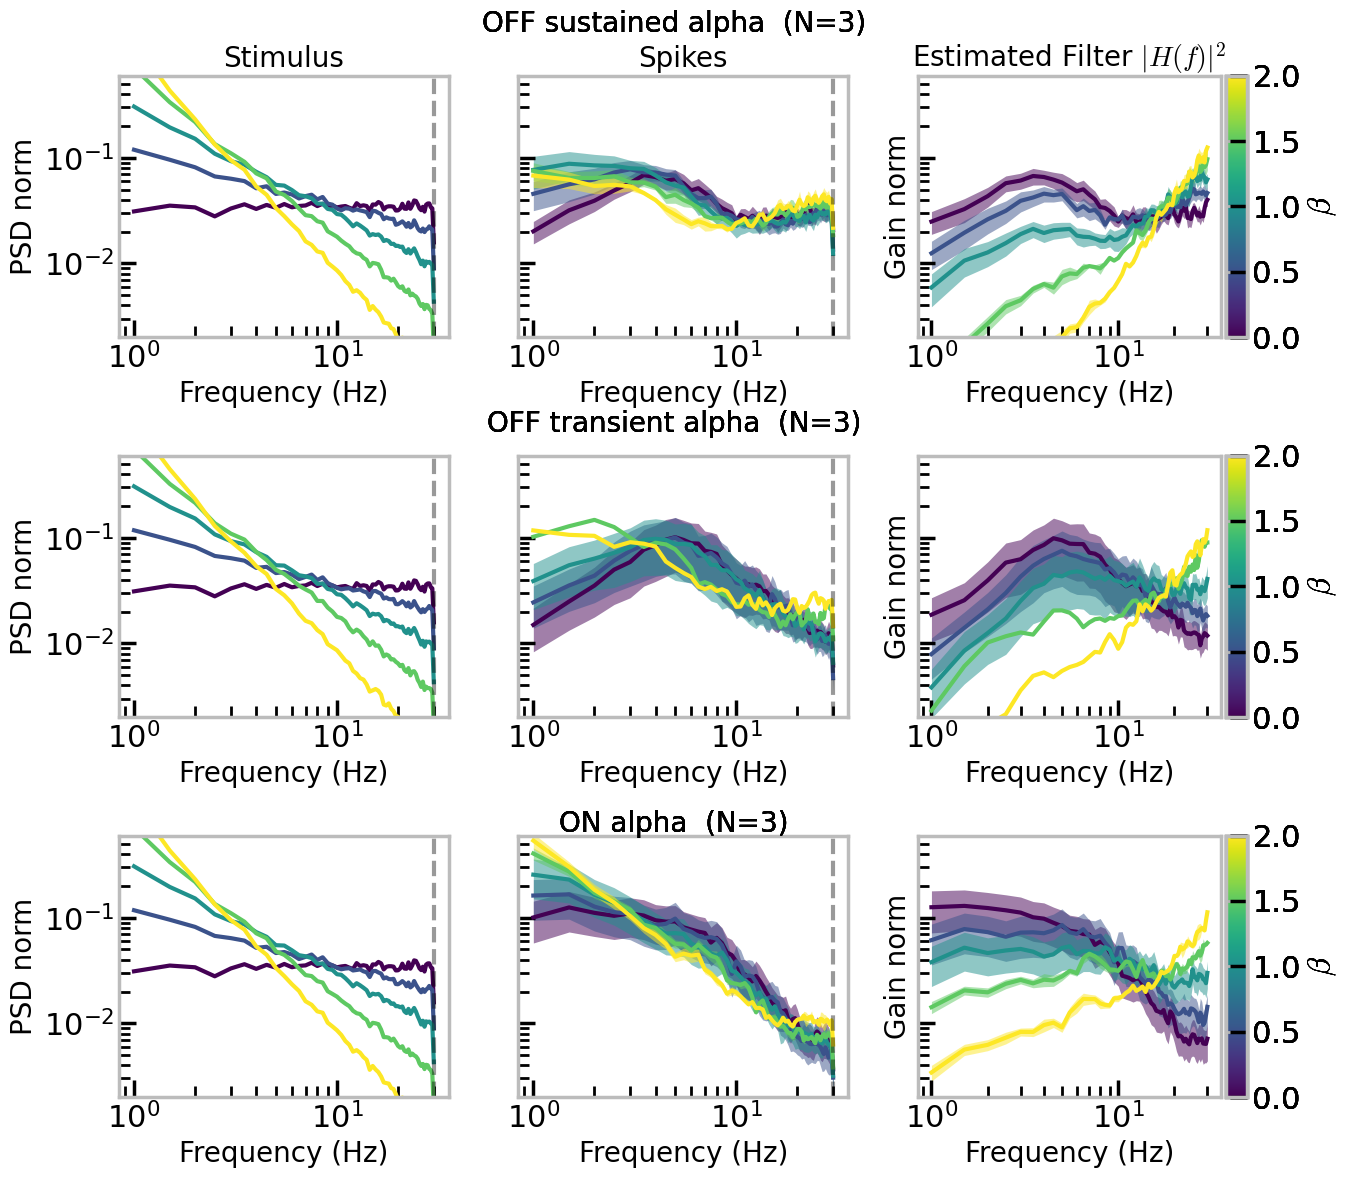

In [ ]:
label_fontsize = 18

# fig.suptitle(f"{cell_type} population data", fontsize=16, y=.84)
# fig.text(0.91, 0.85, f"N = {n_cells}", ha='right', va='top', fontsize=16)
fig, axes = plt.subplots(len(csv_files), 3, figsize=(14, len(csv_files)*4), sharey=True)
for i, file in enumerate(csv_files):
    cell_type_str = file.replace("_", " ")
    cell_type = cell_type_str.replace("PSD Gain.csv", "")
    print(f"\nProcessing: {cell_type}")

    df_celltype = pd.read_csv(os.path.join("results", file))
    df_celltype = convert_stringified_arrays(df_celltype)

    beta_values = sorted(df_celltype['beta'].unique())
    norm = mcolors.Normalize(vmin=min(beta_values), vmax=max(beta_values))
    cmap = plt.get_cmap('viridis')
    label_fontsize = 20
    n_cells = df_celltype['cell_name'].nunique()
    row_height = 1 / len(csv_files)
    for beta_value in (beta_values):
        # if beta_value > 1.5:
        #     continue
        y_pos = 1 - (i + 0.05) * row_height  
        fig.text(0.5, y_pos, f"{cell_type} (N={n_cells})",
             fontsize=label_fontsize, ha='center', va='center')
        color = cmap(norm(beta_value))
        data_beta = df_celltype[df_celltype['beta'] == beta_value]
        
        freqs = df_celltype[df_celltype['beta'] == beta_value]['freq'].iloc[0]
        stim_psd = df_celltype[df_celltype['beta'] == beta_value]['stim_psd'].iloc[0]
        
        nr_psd_stack = np.stack(data_beta['nr_spikes_psd'].values)
        gain_stack = np.stack(data_beta['H_f_power_nr'].values)

        # Compute mean & SEM (excluding DC)
        mean_nr_spikes_psd = np.mean(nr_psd_stack[:, 1:], axis=0)
        sem_nr_spikes_psd = np.std(nr_psd_stack[:, 1:], axis=0) / np.sqrt(n_cells)

        mean_gain = np.mean(gain_stack[:, 1:], axis=0)
        sem_gain = np.std(gain_stack[:, 1:], axis=0) / np.sqrt(n_cells)
        norm_factor_g = np.trapz(mean_gain, freqs[1:])
        mean_gain /= norm_factor_g
        sem_gain /= norm_factor_g

        # Normalize mean spike PSD and SEM
        norm_factor = np.trapz(mean_nr_spikes_psd, freqs[1:])
        mean_nr_spikes_psd /= norm_factor
        sem_nr_spikes_psd /= norm_factor
        
        axes[i, 0].loglog(freqs[1:], stim_psd[1:] / np.trapz(stim_psd[1:], freqs[1:]), c=color)

        axes[i, 1].loglog(freqs[1:], mean_nr_spikes_psd, label=fr"$\mathrm{{Mean}} \pm \mathrm{{s.e.m.}}$", color=color)
        axes[i, 1].fill_between(freqs[1:], 
                            mean_nr_spikes_psd - sem_nr_spikes_psd,
                            mean_nr_spikes_psd + sem_nr_spikes_psd,
                            color=color, alpha=0.5, linewidth=0)

        axes[i, 2].loglog(freqs[1:], mean_gain, color=color)
        axes[i, 2].fill_between(freqs[1:], 
                            mean_gain - sem_gain,
                            mean_gain + sem_gain,
                            color=color, alpha=0.5, linewidth=0)
        # axes[i, 2].set_yticklabels([])

        # Colorbar for beta
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        divider = make_axes_locatable(axes[i,2])
        cax = divider.append_axes("right", size="7%", pad=0.05)
        cbar = plt.colorbar(sm, cax=cax)
        cbar.set_label(r'$\beta$', fontsize=22)


titles = ["Stimulus", "Spikes", r"Estimated Filter $|H(f)|^2$"]
ylabels = ["PSD norm", "PSD norm", "Gain norm"]
fig.patch.set_facecolor('white')     
for row_idx in range(len(csv_files)):
    for col_idx in range(3):
        ax = axes[row_idx, col_idx]
        ax.set_facecolor('white')
        ax.set_xlabel("Frequency (Hz)", fontsize=label_fontsize)
        ax.grid(visible=False)
        ax.set_ylim(2e-3, .6)
        if col_idx == 0:
            ax.set_ylabel(ylabels[col_idx], fontsize=label_fontsize)
        if col_idx == 2:
            ax.set_ylabel(ylabels[col_idx], fontsize=label_fontsize)
        if row_idx == 0:
            ax.set_title(titles[col_idx], fontsize=label_fontsize)

        if col_idx != 2:  # optional vertical line
            ax.axvline(frame_rate / 2, color='k', alpha=0.4, linestyle='--')


plt.tight_layout()

plt.show()